# Market-basket analysis of book reviews on Amazon

This notebook is a project work on the «Algorithms for massive data» course of DSE 2024/2025.\
Student: Timur Rezepov, 34177A

The market-basket analysis is used to describe many-many relationship between two kinds of objects.

The results of market-basket analysis can be presented in the form of association rules: *I -> j*, where j\
is an item.

The core concepts of market-basket analysis are:
- frequent itemset - the set of items *I* which appears in the number of baskets as a subset;
- support - the number of baskets for which I is a subset;
- confidence of the rule *I -> j* -  is the fraction of the baskets with all of I that also contain j.

These association rules can be used in a various ways: recommendations, cross-selling, bundle strategies.

The project is based on based on the [Amazon Books Review](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews) dataset. \
The subjects of market-basket analysis:
- `items` - books
- `baskets` - reviews made by a same user

Books_rating.csv will be used as it's data is sufficient for the analysis.

The theoretical concepts and solution approaches are mostly based on the textbook Mining of Massive Datasets(A. Rajaraman, J. Ullman)

# Dataset

In [1]:
import pandas as pd
import random
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import os
import zipfile

os.environ['KAGGLE_USERNAME'] = "XXXX"
os.environ['KAGGLE_KEY'] = "XXXX"

#!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p data/

path_to_zip_file = 'data/amazon-books-reviews.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('data')

dataset_path = 'data/Books_rating.csv'

In [3]:
def get_df(sample: bool, with_texts: bool = False) -> pd.DataFrame:
    fields = ['Id', 'Title', 'User_id']
    if with_texts is True:
        fields.append('review/text')
    
    if sample is True:
        n = 3000000 #number of records in file
        s = 30000 #desired sample size
        skip = sorted(random.sample(range(n),n-s))
        skip.pop(0)
        df = pd.read_csv(dataset_path, skiprows=skip, usecols=fields)
    else: 
        df = pd.read_csv(dataset_path, usecols=fields)

    columns = ['id', 'title', 'user_id']
    if with_texts is True:
        columns.append('text')
    df.columns = columns
    
    return df

## Preprocessing

In [4]:
df = get_df(sample=True, with_texts=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       30001 non-null  object
 1   title    30000 non-null  object
 2   user_id  24371 non-null  object
 3   text     30001 non-null  object
dtypes: object(4)
memory usage: 937.7+ KB


In [5]:
df[df.duplicated(['text','user_id'])].head()

,id,title,user_id,text
612,B000GL8UMI,Fahrenheit 451,A14I9UW7217ZVS,In a world where imagination and fantasy are s...
1673,B000GY0PV4,The Two Towers,A172VRBP4BZXK6,This is the third book in the Lord of the Ring...
3902,1844560333,Pride and Prejudice,A1UETDSYJJHYYW,"It is generally considered a pretty, romantic ..."
4413,0460872702,Great Gatsby (Everyman),AMF0BX8A2I5SO,An interesting story about that time in histor...
4807,1582343632,Alice's Adventures in Wonderland and Through t...,A3H9SNCYD73G0L,The book Alice in wonderland starts when Alice...


There are 2 issues with the dataset
1. Missing values in user_id column;
2. Duplicated review texts. Such cases don't contain any useful data in the context of market-basket analysis.

In [6]:
df = df[~df["user_id"].isna()]
df = df[~df.duplicated(['user_id','text'])]

In [7]:
baskets = df.groupby('user_id')['id'].agg(['unique'])
basket_cnt = len(baskets)
item_cnt = len(df['id'].unique())
print (f'Number of baskets: {basket_cnt}')
print (f'Number of unique items: {item_cnt}')

Number of baskets: 22037
Number of unique items: 15175


In [8]:
print ('Histogram of number of reviews by the same users (or basket sizes)')
baskets['size'] = baskets['unique'].map(len)
round(baskets.groupby('size').count()/basket_cnt*100).rename(columns={'unique': 'share, %'}).reset_index().head()

Histogram of number of reviews by the same users (or basket sizes)


,size,"share, %"
0,1,95.0
1,2,3.0
2,3,1.0
3,4,0.0
4,5,0.0


A vast majority of users have only one review. So, I will limit the analysis to analysing frequent pairs (doubletons).

In [9]:
df['id_int'], _ = pd.factorize(df['id'])
df[['user_id', 'id', 'id_int']].head()

,user_id,id,id_int
0,A16FTKP8BXKGHG,0595344550,0
1,ARI272XF8TOL4,0802841899,1
2,A15PHIKUFT0A7U,0781810698,2
3,A21C1RB2DFVVXW,0671551345,3
5,A1U9ER7YMUEVLZ,B0000630MU,4


# Implementation

## A-Priori Algorithm

The A-Priori Algorithm is designed to reduce the number of pairs that must be counted, at the expense of performing two passes over data, rather than one pass.

### Which of the items are frequent as singletons?

In [10]:
def count_pairs(n, r):
    return int(math.factorial(n)/math.factorial((n-r))/math.factorial(r))

In [11]:
singleton_support = df\
    .groupby('id_int')['id_int']\
    .count().reset_index(name='cnt')\
    .sort_values(by='cnt').drop(['id_int'], axis=1)
singleton_support["support"] = singleton_support["cnt"]/basket_cnt*100

Typical support threshold value is 1% of baskets, but this value may vary depending \
on the particular dataset. I will estimate using different threshold.

In [13]:
max_sup = singleton_support["support"].max()
min_sup = singleton_support["support"].min()
step = (max_sup - min_sup) / 10

for thresh in np.arange(min_sup, max_sup, step):
    cnt = len(singleton_support[singleton_support["support"] > thresh])
    if cnt > 1:
        pairs_cnt = count_pairs(cnt, 2)
        mem = pairs_cnt*28/1000 # 28 bytes - typical size of int instance in Python 
        print (f'Threshold {thresh:.2f}:\n  frequent singletons {cnt}\n  pairs {pairs_cnt} \n  memory {mem} Kb \n')

Threshold 0.00:
  frequent singletons 3327
  pairs 5532801 
  memory 154918.428 Kb 

Threshold 0.02:
  frequent singletons 489
  pairs 119316 
  memory 3340.848 Kb 

Threshold 0.04:
  frequent singletons 173
  pairs 14878 
  memory 416.584 Kb 

Threshold 0.06:
  frequent singletons 62
  pairs 1891 
  memory 52.948 Kb 

Threshold 0.08:
  frequent singletons 29
  pairs 406 
  memory 11.368 Kb 

Threshold 0.10:
  frequent singletons 15
  pairs 105 
  memory 2.94 Kb 

Threshold 0.12:
  frequent singletons 11
  pairs 55 
  memory 1.54 Kb 

Threshold 0.14:
  frequent singletons 10
  pairs 45 
  memory 1.26 Kb 

Threshold 0.16:
  frequent singletons 8
  pairs 28 
  memory 0.784 Kb 

Threshold 0.18:
  frequent singletons 3
  pairs 3 
  memory 0.084 Kb 



In [14]:
support_thresh = 0.11

singleton_support["frequent"] = singleton_support["support"].apply(lambda x: 1 if x > support_thresh else 0)
singleton_support = singleton_support[singleton_support["frequent"] == 1]

labels, ids = pd.factorize(singleton_support.index.unique())
label_to_id = dict(zip(labels, ids))
singleton_support['id_int'], _ = pd.factorize(singleton_support.index)

frequent_items = list(singleton_support.index)

print (len(frequent_items))

14


Now we can count frequent doubletons.\
We won't miss any frequent doubletons, because have selected all frequent singletons.

First of all, we will select baskets, where our frequent items are met.

In [15]:
df_frequent = df[df["id_int"].apply(lambda x: x in frequent_items)]

baskets = df_frequent.groupby('user_id')['id_int'].agg(['unique'])
baskets['size'] = baskets['unique'].map(len)
baskets = baskets[baskets['size'] > 1]

print (f'Count of baskets with frequent items: {len(baskets)}')

Count of baskets with frequent items: 0


In [16]:
from itertools import combinations  

pairs = list(combinations(frequent_items, 2))
print (f'Count of candidate pairs: {len(pairs)}')

Count of candidate pairs: 91


In [17]:
loc = 0
data = []
for p in pairs:
    rows = baskets[baskets['unique'].apply(lambda x: p[0] in x and p[1] in x)]
    cnt = len(rows)

    if cnt > 0:
        data.append({'i': p[0], 'j': p[1], 'c': cnt})

frequent_items_share = len(data)/len(pairs)*100
print (f"Share of frequent items: {frequent_items_share:.1f}%")

Share of frequent items: 0.0%


In [18]:
%%timeit -n 3

loc = 0
data = []
for p in pairs:
    rows = baskets[baskets['unique'].apply(lambda x: p[0] in x and p[1] in x)]
    cnt = len(rows)

    if cnt > 0:
        data.append({'i': p[0], 'j': p[1], 'c': cnt})

31.3 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


## PCY (sort of)

**Problem:** only 10% of canditate pairs are frequent. \
Need to perform some frequency evaluation before the doubletons computation.

In this implementation I will not generate all possible candidate pairs and loop through them with dataframe lookups.

Instead, I will go through each basket with frequent items and implement a bucket (=pair) counter \
while examining baskets.

In [19]:
baskets = df_frequent.groupby('user_id')['id_int'].apply(list)
baskets = baskets[baskets.apply(len) > 1]

print (f'Count of baskets with frequent items: {len(baskets)}')

Count of baskets with frequent items: 1


In [20]:
%%timeit -n 3

hash_buckets = {}

for basket in baskets:
    if len(basket) < 2:
        continue
    for i in range(len(basket)):
        for j in range(i+1, len(basket)):
            pair = sorted([basket[i], basket[j]])
            bucket_idx = tuple(pair)
            hash_buckets[bucket_idx] = hash_buckets.get(bucket_idx, 0) + 1 

data = []
for k, v in hash_buckets.items():
    data.append({'i': k[0], 'j': k[1], 'c': v})

The slowest run took 5.43 times longer than the fastest. This could mean that an intermediate result is being cached.
5.75 μs ± 5.09 μs per loop (mean ± std. dev. of 7 runs, 3 loops each)


The PCY performance is times faster.

# Full dataset

In [21]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    # Exclude rows with null user_id
    df = df[~df["user_id"].isna()]
    df = df[~df.duplicated(['user_id','id'])]
    df['id_int'], _ = pd.factorize(df['id'])
    return df 

def get_frequent_items(df: pd.DataFrame, support_threshold: float, basket_cnt):
    singleton_support = df\
        .groupby('id_int')['id_int']\
        .count().reset_index(name='cnt')\
        .sort_values(by='cnt').drop(['id_int'], axis=1)
    singleton_support["support"] = singleton_support["cnt"]/basket_cnt*100

    singleton_support["frequent"] = singleton_support["support"].apply(lambda x: 1 if x > support_threshold else 0)
    singleton_support = singleton_support[singleton_support["frequent"] == 1]
    
    labels, ids = pd.factorize(singleton_support.index.unique())
    label_to_id = dict(zip(labels, ids))
    singleton_support['id_int'], _ = pd.factorize(singleton_support.index)
    
    return list(singleton_support.index)

In [22]:
df = get_df(sample=False)
df = process_df(df)

basket_cnt = len(df['user_id'].unique())
item_cnt = len(df['id'].unique())

print (f'Df size: {len(df)}')
print (f'Number of baskets: {basket_cnt}')
print (f'Number of unique items: {item_cnt}')

Df size: 2397614
Number of baskets: 1008972
Number of unique items: 216023


In [23]:
frequent_items = get_frequent_items(df, 0.3, basket_cnt)
df_frequent = df[df["id_int"].apply(lambda x: x in frequent_items)]
print ('Frequent items count: ', len(frequent_items))

Frequent items count:  10


## A-Priori

In [24]:
def run_apriori(baskets: pd.DataFrame, pairs: list):
    loc = 0
    data = []
    for p in pairs:
        p = sorted([p[0], p[1]])
        rows = baskets[baskets['unique'].apply(lambda x: p[0] in x and p[1] in x)]
        cnt = len(rows)
    
        if cnt > 0:
            data.append({'i': p[0], 'j': p[1], 'c': cnt})
            
    return data

In [25]:
from itertools import combinations  

baskets = df_frequent.groupby('user_id')['id_int'].agg(['unique'])
baskets['size'] = baskets['unique'].map(len)
baskets = baskets[baskets['size'] > 1]

print (f'Count of baskets with frequent items: {len(baskets)}')

pairs = list(combinations(frequent_items, 2))
print (f'Count of candidate pairs: {len(pairs)}')

Count of baskets with frequent items: 3575
Count of candidate pairs: 45


In [26]:
%%time
data = run_apriori(baskets, pairs)

CPU times: user 1.53 s, sys: 16.2 ms, total: 1.55 s
Wall time: 1.59 s


In [27]:
df_pairs = pd.DataFrame(data)
df_pairs = df_pairs.reset_index(drop=True).sort_values(by=['i', 'j'])
print (f'Count of frequent pairs: {len(df_pairs)}')

Count of frequent pairs: 45


## PCY

In [28]:
def get_frequent_pairs_pcy(baskets_series: pd.core.series.Series):
    hash_buckets = {}

    for basket in baskets_series:
        if len(basket) < 2:
            continue
        for i in range(len(basket)):
            for j in range(i+1, len(basket)):
                pair = sorted([basket[i], basket[j]])
                bucket_idx = tuple(pair)
                hash_buckets[bucket_idx] = hash_buckets.get(bucket_idx, 0) + 1 
    
    data = []
    for k, v in hash_buckets.items():
        data.append({'i': k[0], 'j': k[1], 'c': v})
    return data

In [29]:
baskets = df_frequent.groupby('user_id')['id_int'].apply(list)
baskets = baskets[baskets.apply(len) > 1]

In [30]:
%%time
data = get_frequent_pairs_pcy(baskets)

CPU times: user 85.6 ms, sys: 3.08 ms, total: 88.7 ms
Wall time: 88.5 ms


In [31]:
df_pairs_pcy = pd.DataFrame(data)

df_pairs_pcy = df_pairs_pcy.sort_values(by=['i', 'j']).reset_index(drop=True)
df_pairs = df_pairs.sort_values(by=['i', 'j']).reset_index(drop=True)

print (f'Count of frequent pairs: {len(df_pairs_pcy)}')
print (f'Count of rows different in two dataframes: {len(df_pairs.compare(df_pairs_pcy))}')

Count of frequent pairs: 45
Count of rows different in two dataframes: 0


There is no difference between the resulting pairs count produced by two implementaions of full dataset.\
But the PCY implementation if faster: ~100 vs 1800 milliseconds.

## Memory tests

In this part I would like to evaluate how this market-basket implementation scales in terms of used memory. \
I will compare the total memory size used by objects in the environment for two cases:
- part of the dataset
- full dataset

In [32]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

def get_memory_used(objects):
    objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in objects])
    mem = round(sum([o[1] for o in objects])/10e6)
    print (f"Memory used (MB): {mem}")
    return objects

In [33]:
def run_pcy(df, pairs_count_func, support_threshold: float=0.1, verbose: bool=True):
    
    basket_cnt = len(df['user_id'].unique())
    item_cnt = len(df['id'].unique())

    frequent_items = get_frequent_items(df, support_threshold, basket_cnt)
    df_frequent = df[df["id_int"].apply(lambda x: x in frequent_items)]

    baskets = df_frequent.groupby('user_id')['id_int'].apply(list)
    baskets = baskets[baskets.apply(len) > 1]
    
    data = pairs_count_func(baskets)
    
    if verbose is not False:
        print (f'Dataset size: {len(df)}')
        print (f'Number of baskets: {basket_cnt}')
        print (f'Number of unique items: {item_cnt}')
        print ('Frequent items count: ', len(frequent_items))
        get_memory_used(dir())
        
    return pd.DataFrame(data)

In [34]:
print ('-----Run on a sample-----')
df = get_df(sample=True, with_texts=False)
df = process_df(df)
df_pairs = run_pcy(df, get_frequent_pairs_pcy, True)

print ('\n-----Run on a full dataset-----')
df = get_df(sample=False, with_texts=False)
df = process_df(df)
df_pairs = run_pcy(df, get_frequent_pairs_pcy, True)

-----Run on a sample-----
Dataset size: 24372
Number of baskets: 21957
Number of unique items: 15021
Frequent items count:  0
Memory used (MB): 1

-----Run on a full dataset-----
Dataset size: 2397614
Number of baskets: 1008972
Number of unique items: 216023
Frequent items count:  0
Memory used (MB): 55


I would say that the PCY implementation scales well enough: 
to process a 100 times larger dataset the we need 54 MB of RAM more.

## Selecting frequent items using MapReduce

Although the full dataset is processed pretty quickly I would like to implement the map reduce algorithm in order to make faster. 

I won't use any external libraries, the solution will be based on python multiprocessing.\
Analysing the data processing steps, I have come to the conclusion that the slowest part is selecting baskets with frequent items.
My MapReduce implemention will consist of:\
**Map step**: check if a basket contains any of the frequent items\
**Reduce step**: aggregate the results

In [45]:
import multiprocess as mp
import matplotlib.pyplot as plt


class MapReduce:
    def __init__(self, num_workers, map_func, reduce_func):
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = mp.Pool(num_workers)
        self.num_workers = num_workers

    def __call__(self, inputs):
        chunksize = int(len(inputs)/self.num_workers)
        map_responses = self.pool.map(self.map_func, inputs, chunksize=chunksize)
        reduced = self.reduce_func(map_responses)
        
        return reduced

In [36]:
def select_by_frequent_items(part):
    if part['id_int'] in frequent_items:
        return part
    return

def reduce(responses):
    result = []
    for resp in responses:
        if resp is not None:
            result.append(resp)
    return result

In [37]:
frequent_items = get_frequent_items(df, 0.1, basket_cnt)

In [38]:
import time
start = time.process_time()

row_counts = [100, 1000, 10000, 100000, 1000000, 5000000]

data_timing = []
for row_count in row_counts:
    df_frequent = df.iloc[:row_count][df["id_int"].apply(lambda x: x in frequent_items)]
    
    delta = time.process_time() - start
    start = time.process_time()

    data_timing.append({"rows": row_count, "time": delta, "implementation": "pandas"})

In [39]:
mr = MapReduce(8, select_by_frequent_items, reduce)

Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/miniconda3/envs/massive_algos_env/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/massive_algos_env/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/massive_algos_env/lib/python3.12/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/massive_algos_env/lib/python3.12/site-packages/multiprocess/

In [40]:
start = time.process_time()

for row_count in row_counts:
    data = mr(df.iloc[:row_count].to_dict('records'))
    df_frequent_2 = pd.DataFrame(data)
    
    delta = time.process_time() - start
    start = time.process_time()
    data_timing.append({"rows": row_count, "time": delta, "implementation": "custom MR"})

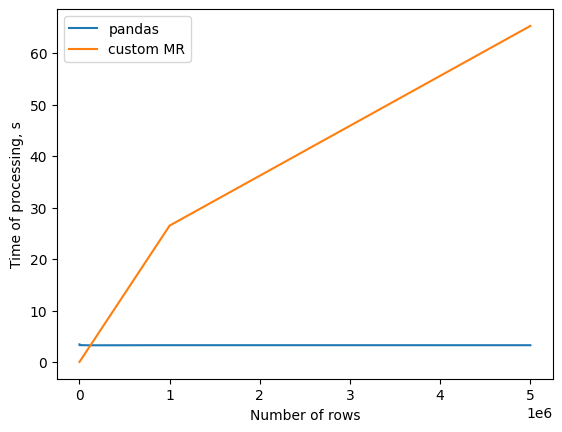

In [46]:
df_comp = pd.DataFrame(data_timing)
for impl in ["pandas", "custom MR"]:
    data = df_comp[df_comp["implementation"] == impl]
    plt.plot(data["rows"], data["time"], label = impl)

plt.legend()
plt.xlabel("Number of rows")
plt.ylabel("Time of processing, s")
plt.show()

The analysis of time required for selecting rows with frequent items shows that the custom MapReduce implementation performs faster than pandas filtering at small dataset sizes (up to hundreds of thousands of rows).

The pandas selection performs almost at a constant time, while custom implementation needs more time as dataset becomes larger.\
This fact may highlight the drawbacks of custom implementation , persumably, in the reduce algorithm.

# Market-basket analysis continued

Often support alone as a metric can be misleading: for example, the support of the association rule of two independently popular items might be high, but such rules are useless from marketing point of view.
`confidence` and `lift` metrics can help us gain more valuable insights.

- confidence of the rule I -> j - is the fraction of the baskets with all of I that also contain j. Confidence has a direction, so there will be two calculations for each pair;
- interest of the rule I -> j: the difference between its confidence and the fraction of baskets that contain j;

I will also use cosine similarity to clear the associations rules a bit and get rid of similar objects in the results.

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char')

def get_cosine_similarity(item_1, item_2):
    return cosine_similarity(vectorizer.transform([item_1]), vectorizer.transform([item_2]))[0][0]

In [48]:
df = get_df(sample=False)
df = process_df(df)

basket_cnt = len(df['user_id'].unique())

singleton_support = df\
    .groupby('id_int')['id_int']\
    .count().reset_index(name='cnt')
singleton_support["fraction"] = singleton_support["cnt"]/basket_cnt

id_titles = df[['id_int', 'title']].drop_duplicates().to_dict('records')
id_to_title = {}
for it in id_titles:
    id_to_title[it['id_int']] = it['title']

In [49]:
df_pairs = run_pcy(df, get_frequent_pairs_pcy, 0.1, True)

Dataset size: 2397614
Number of baskets: 1008972
Number of unique items: 216023
Frequent items count:  109
Memory used (MB): 58


In [50]:
df_pairs_2 = df_pairs.copy()
df_pairs_2['i'] = df_pairs['i']
df_pairs_2['i'] = df_pairs['j']
df_pairs = pd.concat([df_pairs_2, df_pairs], ignore_index=True)

df_pairs = df_pairs.sort_values(by='c', ascending=False)
df_pairs.head()

,i,j,c
5811,5836,147599,3561
5,147599,147599,3561
27,147599,147599,3539
5833,119744,147599,3539
18,147599,147599,3535


In [51]:
df_conf = pd.merge(df_pairs, singleton_support[["id_int", "cnt"]], left_on="i", right_on="id_int")
df_conf = pd.merge(df_conf, singleton_support[["id_int", "fraction"]], left_on="j", right_on="id_int")

df_conf = df_conf.rename(columns={'cnt': 'i_support', 'fraction': 'j_fraction'})
df_conf = df_conf[['i', 'j', 'c', 'i_support', 'j_fraction']]

df_conf['confidence'] = df_conf['c']/df_conf['i_support']
df_conf['interest'] = df_conf['confidence'] - df_conf['j_fraction']

df_conf['I_title'] = df_conf['i'].apply(lambda x: id_to_title[x])
df_conf['j_title'] = df_conf['j'].apply(lambda x: id_to_title[x])

df_conf = df_conf.sort_values(by='interest', ascending=False)
df_conf = df_conf[df_conf['I_title'].str.lower() != df_conf['j_title'].str.lower()]

tfidf_matrix = vectorizer.fit_transform(df_conf['I_title'].unique())

df_conf['similarity'] = df_conf.apply(lambda row: get_cosine_similarity(row['I_title'], row['j_title']), axis=1)

In [52]:
df_conf[['I_title', 'j_title', 'confidence', 'interest', 'similarity']][
    (df_conf['interest'] > 0.03)
    & (df_conf['similarity'] < 0.5)
    & (df_conf['confidence'] < 0.9)
    & (~df_conf.duplicated(['I_title', 'j_title']))
].head().round(2)

,I_title,j_title,confidence,interest,similarity
510,The Lord of the Rings Trilogy 3 Volumes,The Hobbit,0.12,0.12,0.48
506,The Lord of the Rings (3 Volume Set),The Hobbit,0.12,0.12,0.49
623,The Great Gatsby,The Catcher in the Rye [Audiobook] [Cd] [Unabr...,0.09,0.08,0.42
614,Great Gatsby (Everyman),The Catcher in the Rye [Audiobook] [Cd] [Unabr...,0.08,0.08,0.40
723,Jane Eyre (Signet classics),Pride and Prejudice,0.08,0.08,0.49


### Chart

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
def get_associations_by_title(title: str) -> list[tuple]:
    associations = []
    recs = df_conf[(df_conf['I_title'] == title) 
        & (df_conf['interest'] > 0.03)
        & (df_conf['similarity'] < 0.5)
    ]['j_title'].unique()
    recs = list(set(r.upper() for r in recs))
    for r in recs:
        if len(r) > 50:
            splits = r.split(' ')
            split_cnt = len(splits)
            half = int(split_cnt/2)
            r = ' '.join(splits[0:half]) + "\n" + ' '.join(splits[half: split_cnt+1])
        associations.append((title, r))
    return associations

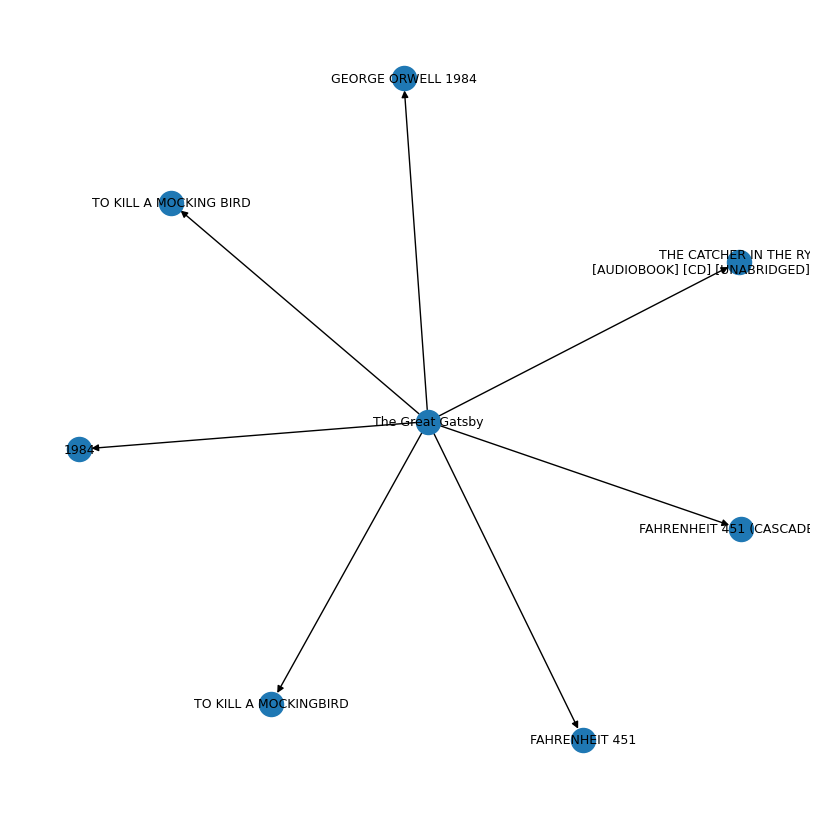

In [55]:
title = 'The Great Gatsby'

G = nx.DiGraph()
G.add_edges_from(get_associations_by_title(title))

plt.figure(3,figsize=(8,8)) 
nx.draw(G, with_labels=True, font_size=9)

plt.show()